In [56]:
import pandas as pd
import os
import plotting
import importlib
importlib.reload(plotting)
pd.options.display.max_rows = 4000
import numpy as np

In [57]:
def load_data(data_src):
    curve_data = [] # used for plotting
    filename_list = []
    for filename in os.listdir(data_src):
        df = pd.read_csv(f"{data_src}/{filename}")
        curve_data.append(df)
        filename_list.append(filename)
    return curve_data, filename_list

data_src = "data/cleaned_data"
curve_data, filename_list = load_data(data_src)
filename_to_depth_resist = dict(zip(filename_list, curve_data))

In [58]:
# ylabel_name = 'marions_ylabels_esd_removed'
ylabel_name = 'marions_ylabels'
data_features = pd.read_csv("data/optimal_features.csv")
print(data_features.columns)
data_features['popcorn'] = data_features['popcorn'].astype('boolean')
data_features['clump'] = data_features['clump'].astype('boolean')
clustering_features = plotting.extract_numerical_features(data_features)

Index(['largest_force_drop_size', 'force_mean', 'curve_first_quarter_slope',
       'depth_max', 'largest_force_drop_res', 'filenames', 'marions_ylabels',
       'distances', 'popcorn', 'color', 'plates', 'clump', 'flake',
       'marions_ylabels_nums'],
      dtype='object')


In [59]:
# ylabel_name = 'marions_ylabels_deduction'
ylabel_to_cluster_num = {'Outlier':-1, 'ES-B':0, 'ES-BW':1, 'ES-S':2, 'ES-S-Plates':3, 'ES-D':4, 'LS':5, 'F':6, 'LS/F':7, 'ES-DB':8, 'ES': 9}
cluster_num_to_ylabel = {v: k for k, v in ylabel_to_cluster_num.items()}
data_features[f'{ylabel_name}_nums'] = data_features[ylabel_name].map(ylabel_to_cluster_num)
marions_labeled_data = data_features[data_features[ylabel_name].notna()].copy() # removes NaN's which correspond to non-labled data

In [60]:
def loss(pseudo_labels:pd.Series, actual_labels:pd.Series):
    pseudo_actual_intersection = pseudo_labels.loc[actual_labels.index]
    diff_mask = pseudo_actual_intersection != actual_labels
    diff_labels = pseudo_actual_intersection[diff_mask]
    return diff_labels.index
    
def correct_pseudo_ylabels_to_actual(pseudo_labels:pd.Series, actual_labels:pd.Series, changed_ylabel_idxs) -> pd.Series:
    corrected_pseudo_labels = pseudo_labels.copy()
    corrected_pseudo_labels.loc[changed_ylabel_idxs] = actual_labels
    return corrected_pseudo_labels

# Split Based on Popcorn

/home/liam-bouffard/anaconda3/envs/env3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2742: UserWarning:

X has feature names, but NearestCentroid was fitted without feature names



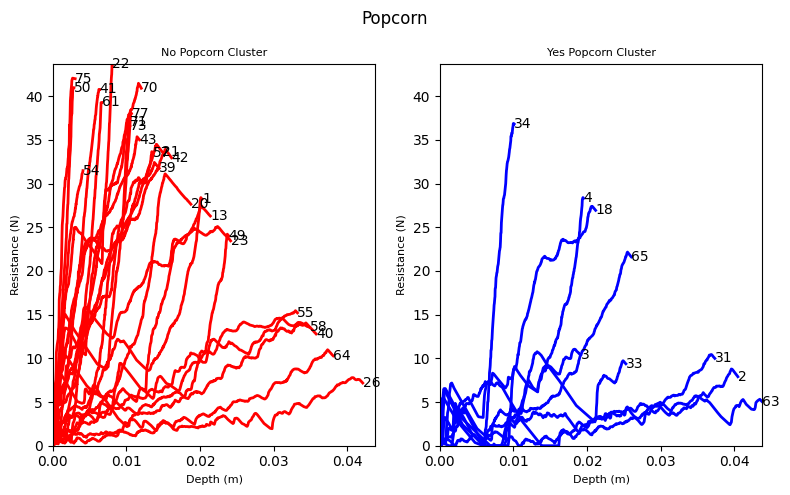

In [61]:
from sklearn.neighbors import NearestCentroid

ylabel_name = "popcorn"
data_with_popcorn_label = data_features[data_features['popcorn'].notna()]

popcorn_x = plotting.extract_numerical_features(data_with_popcorn_label).values
popcorn_ylabels = data_with_popcorn_label['popcorn'].astype(int)

nc = NearestCentroid()
nc.fit(popcorn_x, popcorn_ylabels)

nc_predictions = pd.Series(nc.predict(clustering_features.values))
proba = np.round(nc.predict_proba(clustering_features), 2)

# proba = pd.DataFrame(data=proba, columns=nc.classes, index=data_without_op)
centroids = pd.DataFrame(data=nc.centroids_, columns=clustering_features.columns)
centroids[f'{ylabel_name}_nums'] = nc.classes_

changed_ylabel_idxs = loss(nc_predictions, popcorn_ylabels)
corrected_predctions = correct_pseudo_ylabels_to_actual(nc_predictions, popcorn_ylabels, changed_ylabel_idxs)

# plotting.plot_specific_curves([4], curve_data, data_features, color='green')
# print(data_with_popcorn_label[data_with_popcorn_label['popcorn']][['filenames', 'popcorn']])
# plotting labeled data only
plotting.plot_cluster_subplots(
                            popcorn_ylabels, 
                            curve_data,
                            filename_list,
                            title='Popcorn',
                            cluster_category_names=["No Popcorn", "Yes Popcorn"], 
                            bold_idxs=popcorn_ylabels.index,
                            )
plotting.plot_pca(data_with_popcorn_label, popcorn_ylabels, 3, "", ylabel_name, )

# # plotting labeled with predictions
# plotting.plot_cluster_subplots(
#                             corrected_predctions,
#                             curve_data,
#                             cluster_category_names=["No Popcorn", "Yes Popcorn"],
#                             bold_idxs=popcorn_ylabels.index,
#                             prediction_proba=proba)
# plotting.plot_pca(clustering_features, corrected_predctions, 3, "", ylabel_name=ylabel_name, centroids=centroids)


# Split based on clump

/home/liam-bouffard/anaconda3/envs/env3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2742: UserWarning:

X has feature names, but NearestCentroid was fitted without feature names



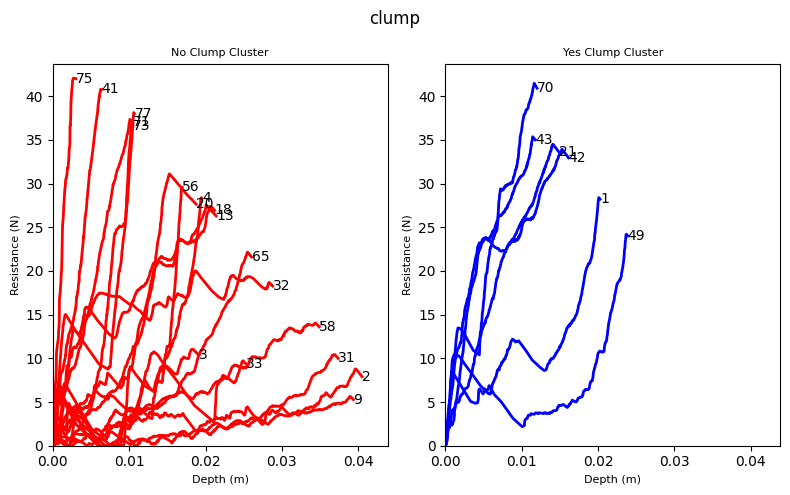

In [62]:
from sklearn.neighbors import NearestCentroid

ylabel_name = "clump"
data_with_popcorn_label = data_features[data_features[ylabel_name].notna()]

popcorn_x = plotting.extract_numerical_features(data_with_popcorn_label).values
popcorn_ylabels = data_with_popcorn_label[ylabel_name].astype(int)

nc = NearestCentroid()
nc.fit(popcorn_x, popcorn_ylabels)

nc_predictions = pd.Series(nc.predict(clustering_features.values))
proba = np.round(nc.predict_proba(clustering_features), 2)

# proba = pd.DataFrame(data=proba, columns=nc.classes, index=data_without_op)
centroids = pd.DataFrame(data=nc.centroids_, columns=clustering_features.columns)
centroids[f'{ylabel_name}_nums'] = nc.classes_

changed_ylabel_idxs = loss(nc_predictions, popcorn_ylabels)
corrected_predctions = correct_pseudo_ylabels_to_actual(nc_predictions, popcorn_ylabels, changed_ylabel_idxs)

# plotting.plot_specific_curves([4], curve_data, data_features, color='green')

# print(data_with_popcorn_label[data_with_popcorn_label[ylabel_name]].index)
# print(data_with_popcorn_label[~data_with_popcorn_label[ylabel_name]].index)

# plotting labeled data only
# plotting.plot_specific_curves([1, 49], curve_data, data_features, color='blue')
# plotting.plot_specific_curves([21, 42, 43, 70], curve_data, data_features, color='blue')

plotting.plot_cluster_subplots(
                            popcorn_ylabels, 
                            curve_data,
                            filename_list,
                            title='clump',
                            cluster_category_names=[f"No {ylabel_name}", f"Yes {ylabel_name}"], 
                            bold_idxs=popcorn_ylabels.index,)
plotting.plot_pca(data_with_popcorn_label, popcorn_ylabels, 3, "", ylabel_name, )


# Flaky

/home/liam-bouffard/anaconda3/envs/env3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2742: UserWarning:

X has feature names, but NearestCentroid was fitted without feature names



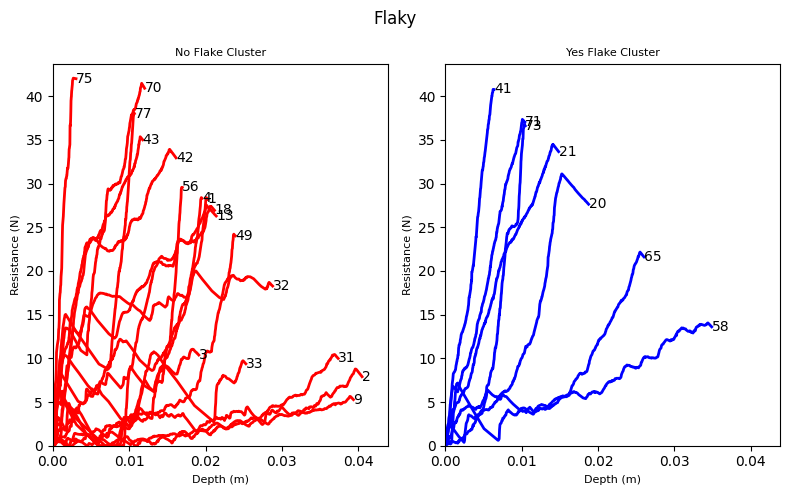

In [63]:
from sklearn.neighbors import NearestCentroid

ylabel_name = "flake"
data_with_popcorn_label = data_features[data_features[ylabel_name].notna()]

popcorn_x = plotting.extract_numerical_features(data_with_popcorn_label).values
popcorn_ylabels = data_with_popcorn_label[ylabel_name].astype(int)

nc = NearestCentroid()
nc.fit(popcorn_x, popcorn_ylabels)

nc_predictions = pd.Series(nc.predict(clustering_features.values))
proba = np.round(nc.predict_proba(clustering_features), 2)

# proba = pd.DataFrame(data=proba, columns=nc.classes, index=data_without_op)
centroids = pd.DataFrame(data=nc.centroids_, columns=clustering_features.columns)
centroids[f'{ylabel_name}_nums'] = nc.classes_

changed_ylabel_idxs = loss(nc_predictions, popcorn_ylabels)
corrected_predctions = correct_pseudo_ylabels_to_actual(nc_predictions, popcorn_ylabels, changed_ylabel_idxs)

# plotting.plot_specific_curves([4], curve_data, data_features, color='green')

# print(data_with_popcorn_label[data_with_popcorn_label[ylabel_name]].index)
# print(data_with_popcorn_label[~data_with_popcorn_label[ylabel_name]].index)

# plotting labeled data only
plotting.plot_cluster_subplots(
                            popcorn_ylabels, 
                            curve_data, 
                            filename_list,
                            title='Flaky',
                            cluster_category_names=[f"No {ylabel_name}", f"Yes {ylabel_name}"], 
                            bold_idxs=popcorn_ylabels.index,
                            )
plotting.plot_pca(data_with_popcorn_label, popcorn_ylabels, 3, "", ylabel_name, )


# Plates

              filenames plates
13  WS23_L3_T1_P_18.csv   True
22  WS23_L2_T1_P_13.csv   True
23   WS23_L2_T1_P_5.csv   True
26   WS23_L2_T1_P_7.csv   True
32   WS23_L3_T1_P_3.csv   True
50  WS23_L2_T1_P_11.csv   True
54  WS23_L2_T1_P_15.csv   True
57  WS23_L2_T1_P_10.csv   True
58  WS23_L3_T1_P_19.csv   True
64   WS23_L2_T1_P_6.csv   True
77  WS23_L3_T1_P_21.csv   True


/home/liam-bouffard/anaconda3/envs/env3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2742: UserWarning:

X has feature names, but NearestCentroid was fitted without feature names



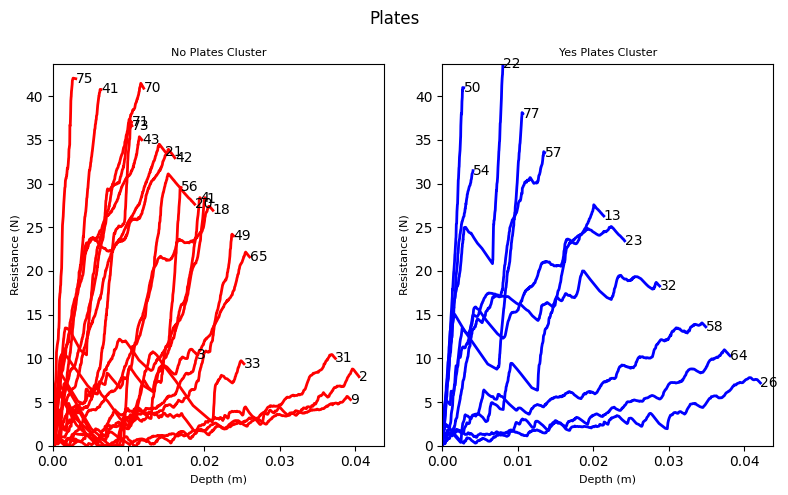

In [64]:
from sklearn.neighbors import NearestCentroid

ylabel_name = "plates"
data_with_popcorn_label = data_features[data_features[ylabel_name].notna()]
print(data_with_popcorn_label[data_with_popcorn_label['plates'] == True][['filenames', 'plates']])

popcorn_x = plotting.extract_numerical_features(data_with_popcorn_label).values
popcorn_ylabels = data_with_popcorn_label[ylabel_name].astype(int)

nc = NearestCentroid()
nc.fit(popcorn_x, popcorn_ylabels)

nc_predictions = pd.Series(nc.predict(clustering_features.values))
proba = np.round(nc.predict_proba(clustering_features), 2)

# proba = pd.DataFrame(data=proba, columns=nc.classes, index=data_without_op)
centroids = pd.DataFrame(data=nc.centroids_, columns=clustering_features.columns)
centroids[f'{ylabel_name}_nums'] = nc.classes_

changed_ylabel_idxs = loss(nc_predictions, popcorn_ylabels)
corrected_predctions = correct_pseudo_ylabels_to_actual(nc_predictions, popcorn_ylabels, changed_ylabel_idxs)

# plotting.plot_specific_curves([32], curve_data, data_features, color='blue')
# plotting.plot_specific_curves([13,58,77], curve_data, data_features, color='blue')

# plotting labeled data only
plotting.plot_cluster_subplots(
                            popcorn_ylabels, 
                            curve_data, 
                            filename_list,
                            title='Plates',
                            cluster_category_names=[f"No {ylabel_name}", f"Yes {ylabel_name}"], 
                            bold_idxs=popcorn_ylabels.index,
                            )
plotting.plot_pca(data_with_popcorn_label, popcorn_ylabels, 3, "", ylabel_name, )


# Dark

/tmp/ipykernel_89218/2062818033.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



    popcorn  color  dark_label
1     False    NaN           0
13    False    NaN           0
20    False    NaN           0
21    False   dark           1
22    False   dark           1
23    False   dark           1
26    False   dark           1
39    False    NaN           0
40    False   dark           1
41    False  white           0
42    False   dark           1
43    False    NaN           0
49    False    NaN           0
50    False   dark           1
54    False   dark           1
55    False    NaN           0
57    False   dark           1
58    False    NaN           0
61    False    NaN           0
64    False   dark           1
70    False    NaN           0
71    False    NaN           0
73    False    NaN           0
75    False    NaN           0
77    False    NaN           0


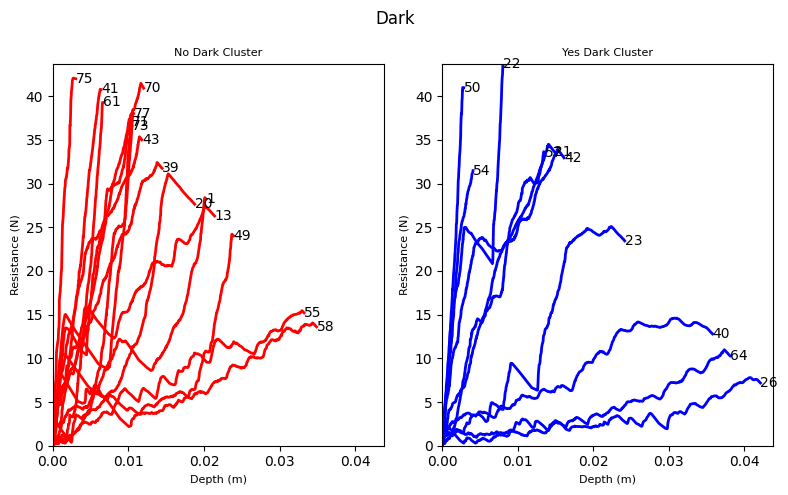

In [65]:
from sklearn.neighbors import NearestCentroid

ylabel_name = "color"
popcorn_data_features = data_features[data_features['popcorn'].notna()].copy()
dark_data_features = popcorn_data_features[popcorn_data_features['popcorn'] == False]
dark_data_features['dark_label'] = dark_data_features['color'].map({'white': 0, np.nan: 0, 'dark': 1})
print(dark_data_features[['popcorn', 'color', 'dark_label']])
popcorn = plotting.extract_numerical_features(data_features).values

plotting.plot_cluster_subplots(
                            dark_data_features['dark_label'], 
                            curve_data, 
                            filename_list,
                            title='Dark',
                            cluster_category_names=[f"No {'Dark'}", f"Yes {'Dark'}"], 
                            )
plotting.plot_pca(dark_data_features, dark_data_features['dark_label'], 3, "", ylabel_name)


# White

/tmp/ipykernel_89218/1564075044.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



    popcorn  color  white_label
2      True  white            1
3      True    NaN            0
4      True  white            1
18     True    NaN            0
31     True  white            1
33     True    NaN            0
34     True    NaN            0
63     True    NaN            0
65     True  white            1


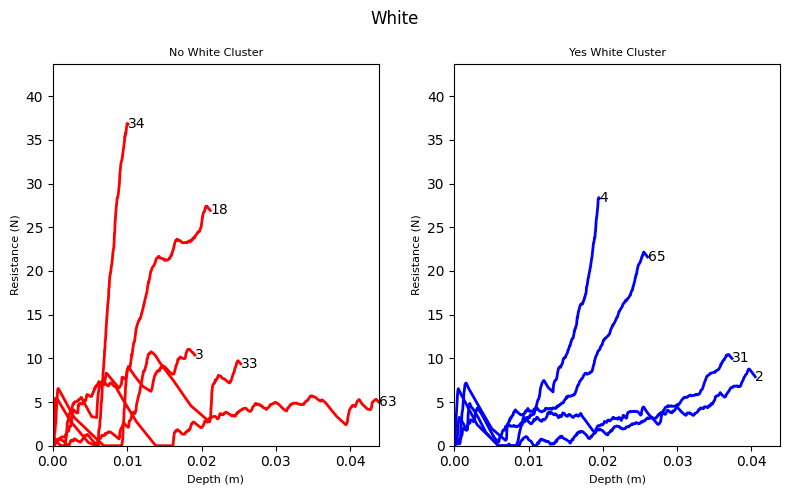

In [66]:
from sklearn.neighbors import NearestCentroid

ylabel_name = "color"
popcorn_data_features = data_features[data_features['popcorn'].notna()].copy()
white_data_features = popcorn_data_features[popcorn_data_features['popcorn'] == True]
white_data_features['white_label'] = white_data_features['color'].map({'dark': 0, np.nan: 0, 'white': 1})
print(white_data_features[['popcorn', 'color', 'white_label']])
popcorn = plotting.extract_numerical_features(data_features).values

plotting.plot_cluster_subplots(
                            white_data_features['white_label'], 
                            curve_data, 
                            filename_list,
                            title='White',
                            cluster_category_names=[f"No {'White'}", f"Yes {'White'}"], 
                            )
plotting.plot_pca(white_data_features, white_data_features['white_label'], 3, "", ylabel_name)
